In [1]:
# Import standard libraries
import pandas as pd
import numpy as np

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Declare variables and import data

In [2]:
# Random value define to ensure the same result is obtained each time the code is run
np.random.seed(0)

In [3]:
# Set the path to the dataset
path_train = "./A1_dataset/Paitients_Files_Train.csv"
path_test = "./A1_dataset/Paitients_Files_Test.csv"

In [4]:
# Load the data
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [5]:
# Review the data
display(train.head(), train.info(), train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


None

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,3.824708,120.153589,68.732888,20.562604,79.460768,31.920033,0.481187,33.290484,0.686144
std,3.362839,32.682364,19.335675,16.017622,116.576176,8.008227,0.337552,11.828446,0.464447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.100000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.000000,32.000000,0.383000,29.000000,1.000000
75%,6.000000,140.000000,80.000000,32.000000,123.500000,36.550000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


# Data Preprocess

We will explore each feature and prepare and organise them into preprocess pipeline for future use. Each feature will be check and update to ensure that they are properly format for our target goal.

In [6]:
# Check for missing values
train.isnull().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

# Visual Exploration
Using visual exploration to find interesting insight on the data

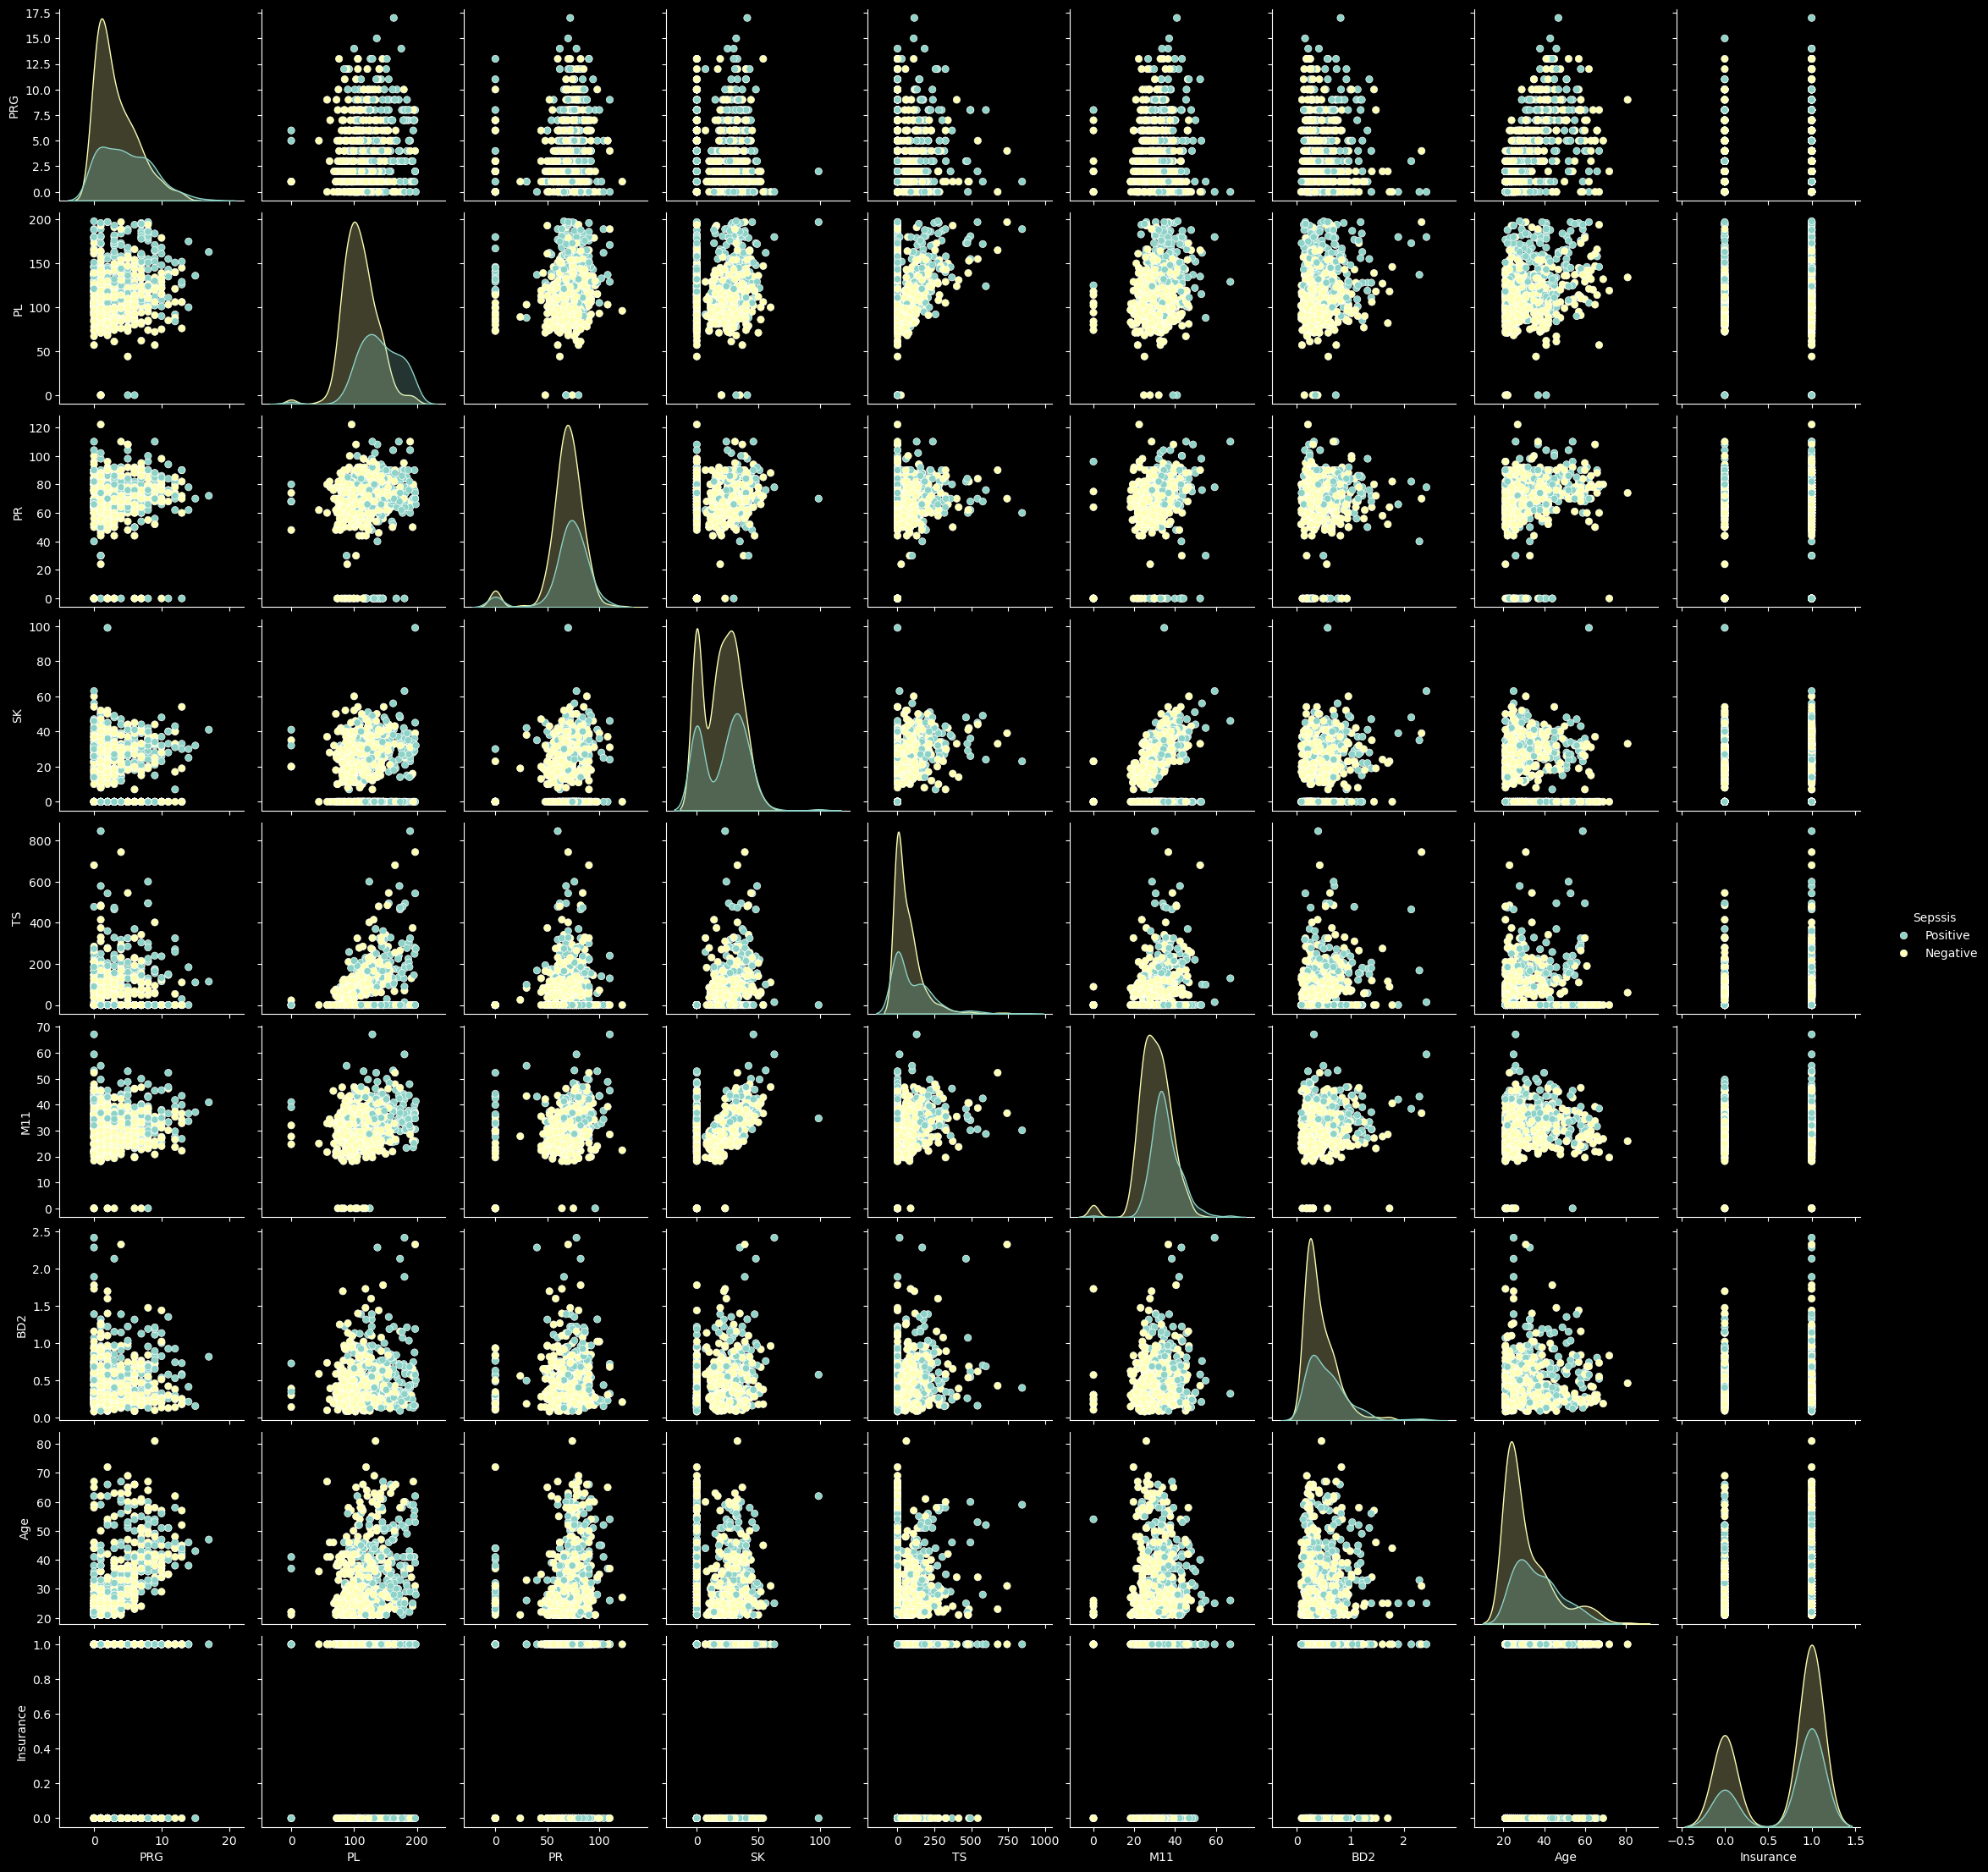

In [10]:
# Pairplot

pairplt = train.drop('ID', axis = 1)
sns.pairplot(pairplt, hue = 'Sepssis')

## Train dev and split

To support the process we will be splitting the training dataset into train-dev set and validate-dev set use for training and validatation

In [ ]:
# Modify the data into features and target
X = train.drop(['ID', 'Sepssis'], axis = 1)
y = train['Sepssis']

In [ ]:
# Train-dev and validation split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Operation Function

In [ ]:
# Function to print the results in fancy way
def output_printing(x_train, x_test, y_train, y_test):
    """
    This function prints the results of the model
    """
    # TODO: create a function to print out the result 
    print("Confusion matrix: ")
    print(confusion_matrix(y_test, y_pred))
    print("The mean squared error is: ", mean_squared_error(y_test, y_pred))
    print("Results for the model")

In [ ]:
# Fit and print the training result (Taken from lab05_Classification_bank notebook for Python Intro to Data Science)
def train_and_plot(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)

    print("Model accuracy for training set: ", model.score(X_train, y_train))
    print("Model accuracy for test set: ", model.score(X_test, y_test))

    y_pred = model.predict(X_test)

    # 

### Pipeline 1: StandardScaler

Using StandardScaler for numeric values to reduce difference

### Pipeline 2: Min max Scaler (Normalizer)

# Model Comparion

Since the task is prediction of the class we will be starting with some simple model and moving it forward:

* ZeroR (Use as benchmark)
* OneR
* Logistic Regression
* Polynominal Logistic Regression
* Simple K-mean
* Decision Tree (Overkill)

Initally each model will be running using the training-dev and using CV technique (we will be using this since there is a small number of dimension in the data) to hyper tune each model. 

In [ ]:
## Logistic Regression

# Final Model Result

Final model is the best model after the use of our above technique, we will then further tune it using the entirer train dataset prior to test it against the test dataset.

In [ ]:
## Final function to output the result.
# predict(final_model, test, "03_TESTPREDICT_s3676330")